In [ ]:
!pip install ucimlrepo --quiet

In [ ]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
from numpy import dot
from numpy.linalg import norm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from typing import List, Tuple
from sklearn.metrics import roc_curve, auc
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import gdown

In [ ]:
nhanes_csv_url = "https://drive.google.com/uc?id=1f780TW51JNg2nLLhjHIEDk-m-NgAEBrO"
output = 'NHANES_age_prediction.csv'
gdown.download(nhanes_csv_url, output)

Downloading...
From: https://drive.google.com/uc?id=1f780TW51JNg2nLLhjHIEDk-m-NgAEBrO
To: /content/NHANES_age_prediction.csv
100%|██████████| 120k/120k [00:00<00:00, 71.9MB/s]


'NHANES_age_prediction.csv'

In [ ]:
NHANES_PATH = "NHANES_age_prediction.csv"

# Loading and Cleaning the Data

In [ ]:
# fetch datasets
# national_health_and_nutrition_health_survey_2013_2014_nhanes_age_prediction_subset = fetch_ucirepo(id=887)
breast_cancer_wisconsin_original = fetch_ucirepo(id=15)
PROCESS=True

data_nhanes = pd.read_csv(NHANES_PATH)
data_nhanes.drop(columns=['SEQN'], inplace=True)

features_name_dict = {'RIDAGEYR': 'Age', 'RIAGENDR': 'Gender', 'BMXBMI': 'BMI',
                      'LBXGLU': 'Glucose', 'LBXGLT': 'Oral', 'LBXIN': 'Blood Insulin',
                      'PAQ605': 'Activness', 'DIQ010': 'Diabetic'}

data_nhanes.rename(columns=features_name_dict, inplace=True)

X_breast = breast_cancer_wisconsin_original.data.features
y_breast = breast_cancer_wisconsin_original.data.targets
data_breast = pd.concat([X_breast, y_breast], axis=1)

# Data Processing
def check_missing_values(dataset: pd.DataFrame, dataset_name: str) -> List:
    '''
    This function takes in the dataset, and its name (for printing purposes).
    It subsequently then finds the variables containing missing values.

    The return value is a list of tuple of the format (var_name, %) where % is the percentage
    of missing values. This will be used later
    '''
    missing_values_variables = dataset.columns[dataset.isna().any()].tolist()
    print('---------------')
    print('Information about Missing Values in {}'.format(dataset_name))
    missing_values_details = []
    if len(missing_values_variables) > 0:
        for column in missing_values_variables:
            n_missing_values = dataset[column].isna().sum()
            percentage_missing_values = n_missing_values/len(dataset)
            missing_values_details.append((column, percentage_missing_values))
            print('Missing Values in {}: {}'.format(column, n_missing_values))
    else:
        print('No Missing Values')
    return missing_values_details

nhanes_missing_values = check_missing_values(data_nhanes, 'NHANES')
breast_missing_values = check_missing_values(data_breast, 'BREAST')

def handle_missing_values(dataset: pd.DataFrame, missing_values_information: List) -> None:
    for column, percentage_missing_value in missing_values_information:
        if percentage_missing_value >= 10:
            mean_column = dataset[column].mean()
            print('Replacing NaN in variable {} by mean value: {}'.format(column, mean_column))
            dataset[column].fillna(mean_column, inplace=True)
        else:
            print('Dropping NaN in variable {}'.format(column))
            dataset.dropna(subset=[column], inplace=True)

handle_missing_values(data_nhanes, nhanes_missing_values)
handle_missing_values(data_breast, breast_missing_values)

def check_duplicates(dataset: pd.DataFrame) -> int:
    return dataset.duplicated().sum()

def handle_duplicates(dataset: pd.DataFrame, dataset_name: str) -> None:
    n_duplicates = check_duplicates(dataset)
    print('Number of duplicates in {}: {}/{}'.format(dataset_name, n_duplicates, len(dataset)))
    if n_duplicates > 0:
        print('Dropping duplicates in {}'.format(dataset_name))
        dataset.drop_duplicates(inplace=True)

handle_duplicates(data_nhanes, 'NHANES')
handle_duplicates(data_breast, 'BREAST')

# Breast Cancer Variables: 4: malignant (positive) , 2: benign (negative)
# Nhanes Variables: Senior (positive), Adult aka non-Senior (positive)

# Basic Statistics
def compute_dataset_stats(dataset: pd.DataFrame, dataset_name: str):
    print('---------------------------- {} Dataset Statistics ----------------------------'.format(dataset_name))
    # convert the categorical data to numerical one
    nhanes_converter = {'Adult': 0, 'Senior': 1}
    if dataset_name == 'NHANES':
        dataset['age_group'] = dataset['age_group'].apply(lambda x: nhanes_converter[x])

    target_variable = {'NHANES': ('age_group', 1, 0), 'BREAST': ('Class', 4, 2)}

    positive = dataset[dataset[target_variable[dataset_name][0]] == target_variable[dataset_name][1]]
    negative = dataset[dataset[target_variable[dataset_name][0]] == target_variable[dataset_name][2]]
    features = positive.columns.tolist()
    stats_dataframe = pd.DataFrame(index=features)
    positive_means, negative_means, squared_diffs = [], [], []

    for feature in features:
        positive_mean = positive[feature].mean()
        negative_mean = negative[feature].mean()

        squared_diff = (positive_mean - negative_mean) ** 2

        positive_means.append(positive_mean)
        negative_means.append(negative_mean)
        squared_diffs.append(squared_diff)

    stats_dataframe[target_variable[dataset_name][1]] = positive_means
    stats_dataframe[target_variable[dataset_name][2]] = negative_means
    stats_dataframe['mean_square_diff'] = squared_diffs
    stats_dataframe.sort_values(by=['mean_square_diff'], ascending=False, inplace=True)

    print(stats_dataframe)

    k = 4
    top_4_ranked_by_squared_difference = stats_dataframe.index.tolist()[:k]
    # compute Spearman aka Rank correlation
    correlation = dataset.corr(method='spearman')[target_variable[dataset_name][0]][:].sort_values(ascending=False)
    top_4_ranked_by_correlation = correlation.index.tolist()[1:k+1] # The first one obviously here will be the target class itself

    print('Top-{} Ranked by Squared Difference: {}'.format(k, top_4_ranked_by_squared_difference))
    print('Top-{} With Spearman Correlation: {}'.format(k, top_4_ranked_by_correlation))

    intersection_set = set(top_4_ranked_by_correlation).intersection(set(top_4_ranked_by_squared_difference))
    print('Top features associated with the target variable: {}'.format(list(intersection_set)))

    if PROCESS:
        dataset = dataset[list(intersection_set) + [target_variable[dataset_name][0]]]
        dataset.to_csv('processed_{}_data_top_{}_features.csv'.format(dataset_name, len(intersection_set)), index=False)
    else:
        dataset.to_csv('processed_{}_data_top_{}_features.csv'.format(dataset_name, len(dataset.columns)-1), index=False)

compute_dataset_stats(data_breast, 'BREAST')
compute_dataset_stats(data_nhanes, 'NHANES')

---------------
Information about Missing Values in NHANES
No Missing Values
---------------
Information about Missing Values in BREAST
Missing Values in Bare_nuclei: 16
Dropping NaN in variable Bare_nuclei
Number of duplicates in NHANES: 0/2278
Number of duplicates in BREAST: 234/683
Dropping duplicates in BREAST
---------------------------- BREAST Dataset Statistics ----------------------------
                                    4         2  mean_square_diff
Bare_nuclei                  7.605932  1.704225         34.830144
Uniformity_of_cell_size      6.563559  1.629108         24.348810
Uniformity_of_cell_shape     6.538136  1.765258         22.780358
Normal_nucleoli              5.902542  1.530516         19.114611
Marginal_adhesion            5.635593  1.652582         15.864377
Clump_thickness              7.203390  3.356808         14.796196
Bland_chromatin              5.978814  2.230047         14.053251
Single_epithelial_cell_size  5.305085  2.300469          9.027713
Class 

- The first dataset (NHANES) contains no missing values and has no duplicate values
- The second dataset (Breast Cancer) has one variable called `Bare_nuclei` has `16` missing values, representing 0.023% of its total number of samples. Consequently we decided just to dynamically drop those values. Additionally, this dataset also has `234` duplicate values (out of `683`), that have been dropped to avoid contamination.

- Datasets Statistics
    - ---------------------------- BREAST Dataset Statistics ----------------------------

                                             Malignant  Benign      mean_square_diff
                Bare_nuclei                  7.627615  1.346847         39.448049
                Uniformity_of_cell_size      6.577406  1.306306         27.784490
                Uniformity_of_cell_shape     6.560669  1.414414         26.483941
                Normal_nucleoli              5.857741  1.261261         21.127622
                Marginal_adhesion            5.585774  1.346847         17.968504
                Clump_thickness              7.188285  2.963964         17.844884
                Bland_chromatin              5.974895  2.083333         15.144255
                Single_epithelial_cell_size  5.326360  2.108108         10.357144
                Class                        4.000000  2.000000          4.000000
                Mitoses                      2.602510  1.065315          2.362969

        - Top-4 Ranked by Squared Difference: ['Bare_nuclei', 'Uniformity_of_cell_size', 'Uniformity_of_cell_shape', 'Normal_nucleoli']

        - Top-4 With Spearman Correlation: ['Uniformity_of_cell_size', 'Uniformity_of_cell_shape', 'Bare_nuclei', 'Single_epithelial_cell_size']

        - Top features associated with the target variable: ['Bare_nuclei', 'Uniformity_of_cell_shape', 'Uniformity_of_cell_size']
    
    - ---------------------------- NHANES Dataset Statistics ----------------------------

                                 Senior       Adult       mean_square_diff
                Age             73.425824   35.780564       1417.165594
                Oral           141.208791  109.990596        974.575736
                Glucose        104.329670   98.644723         32.318625
                Blood Insulin   10.405247   12.106661          2.894810
                age_group        1.000000    0.000000          1.000000
                Activness        1.909341    1.806165          0.010645
                BMI             27.886264   27.968286          0.006728
                Diabetic         2.027473    2.014107          0.000179
                Gender           1.508242    1.512017          0.000014
    
        - Top-4 Ranked by Squared Difference: ['Age', 'Oral', 'Glucose', 'Blood Insulin']
    
        - Top-4 With Spearman Correlation: ['Age', 'Oral', 'Glucose', 'Activness']
    
        - Top features associated with the target variable: ['Oral', 'Age', 'Glucose']


# KNN Implementation

In [ ]:
class Comp551_KNN:
    def __init__(self, distance_metric_name = 'euclidean') -> None:
        self.distance_metric_name = distance_metric_name

    def fit(self, X: np.array, y: np.array, n_neighbors: int=10) -> None:
        self.training_data = X
        self.training_labels = y
        self.n_neighbors = n_neighbors

    def _predict(self, x: np.array) -> int:
        # compute the distances of the new point to the training data
        distances = [self.distance(x, training_point) for training_point in self.training_data]
        # use the distance to get the top-k neighbors
        top_k_neighbors = np.argsort(distances)[:self.n_neighbors]
        # get the labels of the neighbors
        top_k_labels = [self.training_labels[index] for index in top_k_neighbors]
        # now we need to get the most common one
        # let us get first the unique classes
        unique_classes = list(set(top_k_labels))
        # then we can get the count
        unique_classes_count = {class_: top_k_labels.count(class_) for class_ in unique_classes}
        # now let's sort it and have the class with highest frequency
        sorted_unique_classes_count = dict(sorted(unique_classes_count.items(),
                                                  key=lambda item: item[1], reverse=True))
        # best label
        sample_class = list(sorted_unique_classes_count.keys())[0]
        return sample_class

    def _predict_proba(self, x: np.array, dataset_name: str) -> int:
        # compute the distances of the new point to the training data
        distances = [self.distance(x, training_point) for training_point in self.training_data]
        # use the distance to get the top-k neighbors
        top_k_neighbors = np.argsort(distances)[:self.n_neighbors]
        # get the labels of the neighbors
        top_k_labels = [self.training_labels[index] for index in top_k_neighbors]
        # now we need to get the most common one
        # let us get first the unique classes
        unique_classes = list(set(top_k_labels))
        # then we can get the count
        unique_classes_count = {class_: top_k_labels.count(class_) for class_ in unique_classes}

        # best label proba
        if dataset_name == 'BREAST':
            class_dict = {2: 0, 4: 0}
        else:
            class_dict = {0: 0, 1: 0}

        for class_dataset in list(class_dict.keys()):
            try:
                class_dict[class_dataset] = unique_classes_count[class_dataset]/len(top_k_labels)
            except:
                pass
        return list(class_dict.values())

    def predict(self, X: np.array) -> np.array:
        preds = [self._predict(x) for x in X]
        return np.array(preds)

    def predict_proba(self, X: np.array, dataset_name: str) -> np.array:
        preds = [self._predict_proba(x, dataset_name) for x in X]
        return np.array(preds)

    def euclidean(self, xi: np.array, xj: np.array) -> float:
        return np.sqrt(np.sum((xi - xj) ** 2))

    def cosine_similarity(self, xi: np.array, xj: np.array) -> float:
        return dot(xi, xj) / (norm(xi) * norm(xj))

    def manhattan_distance(self, xi: np.array, xj: np.array) -> float:
        return np.sum(np.abs(xi - xj))

    def distance(self, xi: np.array, xj: np.array) -> float:
        if self.distance_metric_name == 'euclidean':
            return self.euclidean(xi, xj)

        if self.distance_metric_name == 'cosine':
            return self.cosine_similarity(xi, xj)

        if self.distance_metric_name == 'manhattan':
            return self.manhattan_distance(xi, xj)

    def evaluate_acc(self, true, predictions):
        return np.mean(true == predictions)

# KNN Experiments

# Experiments: Feature Importance and Impact on Performance
    
  - Experiments (NHANES)

Model | accuracy with all features | accuracy with top-3 features
--- | --- | ---
`Decision Tree` | 1.0 | **1.0**
`KNN` | 0.9672 | **0.9803**

  - Experiments (BREAST CANCER)

Model | accuracy with all features | accuracy with top-3 features |
--- | --- | --- |
`Decision Tree` | 0.9111 | **0.9333** |
`KNN` | 0.9556 | **0.9666** |

Overall, it is obvious that using top-3 features give best results, on both models. Moving on next, we will stick to those 3 features. Those feature were selected as follow:

  - Compute the square difference between both classes for all features, and select the top-k (k==4)
  - Compute the Spearman Rank Correlation between all features and the target variable. Then, select the top-k (k==4)
  - The final set of features used is the intersection of features of the two steps described above

# Experiments: Data Splitting and Saving

In [ ]:
breast_dataset = pd.read_csv('processed_{}_data_top_{}_features.csv'.format('BREAST', 3))
nhanes_dataset = pd.read_csv('processed_{}_data_top_{}_features.csv'.format('NHANES', 3))

def create_dataset_split(dataset: pd.DataFrame, create_val: bool = False) -> Tuple:
    train, test = train_test_split(dataset, test_size=0.2, random_state=42)
    if create_val:
        train, val = train_test_split(train, test_size=0.2, random_state=42)
        return train, val, test
    else:
        return train, test

breast_train, breast_test = create_dataset_split(breast_dataset)
nhanes_train, nhanes_test = create_dataset_split(nhanes_dataset)

breast_train.to_csv('breast_train.csv', index=False)
breast_test.to_csv('breast_test.csv', index=False)

nhanes_train.to_csv('nhanes_train.csv', index=False)
nhanes_test.to_csv('nhanes_test.csv', index=False)

knn_breast = Comp551_KNN()
knn_nhanes = Comp551_KNN()

train_target_breast = breast_train['Class'].values
train_breast_features = breast_train.drop(columns=['Class']).values

train_target_nhanes = nhanes_train['age_group'].values
train_nhanes_features = nhanes_train.drop(columns=['age_group']).values

test_target_breast = breast_test['Class'].values
test_breast_features = breast_test.drop(columns=['Class']).values

test_target_nhanes = nhanes_test['age_group'].values
test_nhanes_features = nhanes_test.drop(columns=['age_group']).values

# Experiments: Importance of `k` hyperparameters

In [ ]:
ks = []
accs_breast = []
accs_nhanes = []
aucs_breast = []
aucs_nhanes = []

for k in range(10, 110, 10):

    ks.append(k)

    knn_breast.fit(train_breast_features, train_target_breast, n_neighbors=k)
    breast_pred = knn_breast.predict(test_breast_features)
    breast_pred_proba = knn_breast.predict_proba(test_breast_features, 'BREAST')
    knn_breat_acc = knn_breast.evaluate_acc(test_target_breast, breast_pred)

    accs_breast.append(knn_breat_acc)

    fpr, tpr, thresholds = roc_curve(test_target_breast, breast_pred_proba[:, 1], pos_label=4)
    roc_auc = auc(fpr, tpr)
    print('{} - Breast KNN Accuracy: {}'.format(k, knn_breat_acc))
    print('{} - Breast AUC ROC: {}'.format(k, roc_auc))

    aucs_breast.append(roc_auc)

    knn_nhanes.fit(train_nhanes_features, train_target_nhanes, n_neighbors=k)
    nhanes_pred = knn_nhanes.predict(test_nhanes_features)
    knn_nhanes_acc = knn_nhanes.evaluate_acc(test_target_nhanes, nhanes_pred)

    accs_nhanes.append(knn_nhanes_acc)
    nhanes_pred_proba = knn_nhanes.predict_proba(test_nhanes_features, 'NHANES')
    fpr_nhanes, tpr_nhanes, thresholds_nhanes = roc_curve(test_target_nhanes, nhanes_pred_proba[:, 1], pos_label=1)
    roc_auc_nhanes = auc(fpr_nhanes, tpr_nhanes)

    aucs_nhanes.append(roc_auc_nhanes)

    print('{} - NHANES KNN Accuracy: {}'.format(k, knn_nhanes_acc))
    print('{} - NHANES AUC ROC: {}'.format(k, roc_auc_nhanes))

saving = pd.DataFrame()

saving['k'] = ks
saving['acc_nhanes'] = accs_nhanes
saving['acc_breast'] = accs_breast
saving['auc_nhanes'] = aucs_nhanes
saving['auc_breast'] = aucs_breast

print(saving)
saving.to_csv('knn_experiments_results.csv', index=False)

10 - Breast KNN Accuracy: 0.9666666666666667
10 - Breast AUC ROC: 0.9957690393230464
10 - NHANES KNN Accuracy: 0.9802631578947368
10 - NHANES AUC ROC: 0.9974175746427056
20 - Breast KNN Accuracy: 0.9666666666666667
20 - Breast AUC ROC: 0.9967645594823296
20 - NHANES KNN Accuracy: 0.9736842105263158
20 - NHANES AUC ROC: 0.9963739917928399
30 - Breast KNN Accuracy: 0.9555555555555556
30 - Breast AUC ROC: 0.9977600796416126
30 - NHANES KNN Accuracy: 0.9692982456140351
30 - NHANES AUC ROC: 0.9954365360124522
40 - Breast KNN Accuracy: 0.9444444444444444
40 - Breast AUC ROC: 0.9975111996017919
40 - NHANES KNN Accuracy: 0.9714912280701754
40 - NHANES AUC ROC: 0.9947997735955851
50 - Breast KNN Accuracy: 0.9444444444444444
50 - Breast AUC ROC: 0.9975111996017919
50 - NHANES KNN Accuracy: 0.9692982456140351
50 - NHANES AUC ROC: 0.993384746002547
60 - Breast KNN Accuracy: 0.9333333333333333
60 - Breast AUC ROC: 0.9975111996017919
60 - NHANES KNN Accuracy: 0.9714912280701754
60 - NHANES AUC ROC: 

# Experiments: Evaluation of different values of `k` hyperparameter for `KNN`

k | acc_nhanes | auc_nhanes | acc_breast | auc_breast
--- | --- | --- | --- | ---
    `10` | 0.980263 | 0.997418 | 0.966667 | 0.995769 |
    `20` | 0.973684 | 0.996374 | 0.966667 | 0.996765 |
    `30` | 0.969298 | 0.995437 | 0.955556 | 0.997760 |
    `40` | 0.971491 | 0.994800 | 0.944444 | 0.997511 |
    `50` | 0.969298 | 0.993385 | 0.944444 | 0.997511 |
    `60` | 0.971491 | 0.992677 | 0.933333 | 0.997511 |
    `70` | 0.967105 | 0.992094 | 0.944444 | 0.997511 |
    `80` | 0.967105 | 0.992058 | 0.933333 | 0.997760 |
    `90` | 0.980263 | 0.991952 | 0.933333 | 0.997511 |
    `100` | 0.980263 | 0.991616 | 0.933333 | 0.997511 |

We decided to stick to AUC to select the optimal `k`. This is because AUC is better when the problem is imbalanced (which is the case here). Given this, AUC is also more robust to changes in the threshold, and can capture the model's performance across the entire range of probabilities. Finally, AUC is also be useful when the cost of false positives and false negatives are different, and need to be balanced. Overall, AUC will allow to select models that achieve false positive and true positive rates that are significantly above random chance, which is not guaranteed for accuracy. Consequently, for `NHANES` and `BREAST CANCER` datasets, the chosen best `k` values are respectively `k=10` and `k=30`. To compute the `AUCROC`, since we need the probablities of the positive class, we have implemented and used the `predict_proba` function. These metrics are computed using the `euclidean` distance function. In the `KNN` class, we have also implemented the `cosine similarity` and the `manhattan distance`.


# Experiments: Importance of Distance Funtion

In [ ]:
# Breast Cancer & NHANES Cost Function Evaluation

metrics = ['euclidean']
accs_breast = [0.955556]
aucs_breast = [0.997760]

accs_nhanes = [0.980263]
aucs_nhanes = [0.997418]

for metric in ['cosine', 'manhattan']:

    metrics.append(metric)
    knn_breast = Comp551_KNN(distance_metric_name=metric)

    knn_breast.fit(train_breast_features, train_target_breast, n_neighbors=30)
    breast_pred = knn_breast.predict(test_breast_features)
    breast_pred_proba = knn_breast.predict_proba(test_breast_features, 'BREAST')
    knn_breat_acc = knn_breast.evaluate_acc(test_target_breast, breast_pred)

    accs_breast.append(knn_breat_acc)

    fpr, tpr, thresholds = roc_curve(test_target_breast, breast_pred_proba[:, 1], pos_label=4)
    roc_auc = auc(fpr, tpr)
    print('{} - Breast KNN Accuracy: {}'.format(metric, knn_breat_acc))
    print('{} - Breast AUC ROC: {}'.format(metric, roc_auc))

    aucs_breast.append(roc_auc)

    knn_nhanes = Comp551_KNN(distance_metric_name=metric)

    knn_nhanes.fit(train_nhanes_features, train_target_nhanes, n_neighbors=10)
    nhanes_pred = knn_nhanes.predict(test_nhanes_features)
    knn_nhanes_acc = knn_nhanes.evaluate_acc(test_target_nhanes, nhanes_pred)

    accs_nhanes.append(knn_nhanes_acc)
    nhanes_pred_proba = knn_nhanes.predict_proba(test_nhanes_features, 'NHANES')
    fpr_nhanes, tpr_nhanes, thresholds_nhanes = roc_curve(test_target_nhanes, nhanes_pred_proba[:, 1], pos_label=1)
    roc_auc_nhanes = auc(fpr_nhanes, tpr_nhanes)

    aucs_nhanes.append(roc_auc_nhanes)

    print('{} - NHANES KNN Accuracy: {}'.format(metric, knn_nhanes_acc))
    print('{} - NHANES AUC ROC: {}'.format(metric, roc_auc_nhanes))

saving = pd.DataFrame()

saving['metrics'] = metrics
saving['acc_nhanes'] = accs_nhanes
saving['acc_breast'] = accs_breast
saving['auc_nhanes'] = aucs_nhanes
saving['auc_breast'] = aucs_breast

print(saving)
saving.to_csv('knn_metrics_experiments_results.csv', index=False)

cosine - Breast KNN Accuracy: 0.36666666666666664
cosine - Breast AUC ROC: 0.2986560477849677
cosine - NHANES KNN Accuracy: 0.7214912280701754
cosine - NHANES AUC ROC: 0.0763761143342295
manhattan - Breast KNN Accuracy: 0.9444444444444444
manhattan - Breast AUC ROC: 0.997511199601792
manhattan - NHANES KNN Accuracy: 0.9824561403508771
manhattan - NHANES AUC ROC: 0.9983196547332673
     metrics  acc_nhanes  acc_breast  auc_nhanes  auc_breast
0  euclidean    0.980263    0.955556    0.997418    0.997760
1     cosine    0.721491    0.366667    0.076376    0.298656
2  manhattan    0.982456    0.944444    0.998320    0.997511


# Experiments: KNN Comparison of Several Distance Functions with the Best Hyperparameters.

  * NHANES Results
    
Model | Euclidean Distance | Cosine Similarity | Manhattan Distance |
--- |:---: | :---: | :---: |
`Accuracy` | 0.980263 | 0.721491 | **0.982456** |
`AUCROC` | 0.997418 | 0.076376 | **0.998320** |

  * BREAST CANCER Results
    
Model | Euclidean Distance | Cosine Similarity | Manhattan Distance |
---: |:---: | :---: | :---: |
`Accuracy` | **0.955556** | 0.366667 | 0.944444 |
`AUCROC` | **0.997760** | 0.298656 | 0.997511 |

We can see that in the case of `NHANES`, the `manhattan distance` works better than the `euclidean distance`. Following might be possible reasons:

  * When the data is high-dimensional, Manhattan distance can better capture the similarity between points than Euclidean distance ([Source](https://datascience.stackexchange.com/questions/20075/when-would-one-use-manhattan-distance-as-opposed-to-euclidean-distance))

  * When the data has different scales or units, Manhattan distance can be more robust to outliers or irrelevant features than Euclidean distance ([Source](https://machinelearningmastery.com/distance-measures-for-machine-learning/))

  * When the data is discrete or categorical, Manhattan distance can be more appropriate than Euclidean distance, which assumes a continuous space ([Source](https://worldnewlive.com/what-is-manhattan-distance-and-euclidean-distance/))

  * `Manhattan distance` uses the L1 Norm which encourages sparsity while `Euclidean Distance` uses the L2 norm.

  * `Manhattan distance` works better input variables are not similar in type (e.g. in `NHANES` they are `Glucose, Oral, and Age` which are high-likely unrelated vs in `BREAST` they are `Bare_nuclei, Uniformity_of_cell_size, and Uniformity_of_cell_shape` which are very likely to be related). Morever, due to the curse of dimensionality, Euclidean distance becomes a poor choice as the number of dimensions increases. This is confirmed by this [MIT Lesson](https://www.youtube.com/watch?v=h0e2HAPTGF4) at 36:15 on the slides the following statement: `...Manhattan may be appropriate if different dimensions are not comparable...`

For the remaining experiments, we have used the `Manhattan` and `Euclidean` distances, respectively for the `NHANES` and `BREAST CANCER` datasets


In [ ]:
# using best parameters and save the results

knn_breast = Comp551_KNN()
knn_breast.fit(train_breast_features, train_target_breast, n_neighbors=30)
breast_pred = knn_breast.predict(test_breast_features)
breast_pred_proba = knn_breast.predict_proba(test_breast_features, 'BREAST')

# manhattan distance for NHANES
knn_nhanes = Comp551_KNN(distance_metric_name='manhattan')
knn_nhanes.fit(train_nhanes_features, train_target_nhanes, n_neighbors=10)
nhanes_pred = knn_nhanes.predict(test_nhanes_features)
nhanes_pred_proba = knn_nhanes.predict_proba(test_nhanes_features, 'NHANES')

breat_predictions = pd.DataFrame()
nhanes_predictions = pd.DataFrame()

breat_predictions['breast_predict'] = breast_pred
breat_predictions['breast_predict_proba'] = breast_pred_proba[:, 1] # we only need the positive class probabilities to compute the ROC
breat_predictions.to_csv('breast_knn_experiments_best_hyperparameters_results.csv', index=False)
print(breat_predictions)

nhanes_predictions['nhanes_predict'] = nhanes_pred
nhanes_predictions['nhanes_predict_proba'] = nhanes_pred_proba[:, 1]
nhanes_predictions.to_csv('nhanes_knn_experiments_best_hyperparameters_results.csv', index=False)
print(nhanes_predictions)

    breast_predict  breast_predict_proba
0                2              0.000000
1                2              0.233333
2                2              0.000000
3                4              0.700000
4                2              0.033333
..             ...                   ...
85               2              0.000000
86               2              0.000000
87               4              1.000000
88               2              0.000000
89               4              0.700000

[90 rows x 2 columns]
     nhanes_predict  nhanes_predict_proba
0                 0                   0.0
1                 0                   0.0
2                 0                   0.0
3                 0                   0.0
4                 0                   0.3
..              ...                   ...
451               0                   0.4
452               0                   0.0
453               0                   0.1
454               1                   0.9
455               0    

# Experiments: Performing K-Fold Cross-Validation

In [ ]:
def kfold_indices(data, k):
    fold_size = len(data) // k
    indices = np.arange(len(data))
    folds = []
    for i in range(k):
        test_indices = indices[i * fold_size: (i + 1) * fold_size]
        train_indices = np.concatenate([indices[:i * fold_size], indices[(i + 1) * fold_size:]])
        folds.append((train_indices, test_indices))
    return folds

In [ ]:
def perform_k_fold_cross_validation(model, train_data: Tuple, test_data: Tuple, dataset_name: str) -> None:
    for k_fold in range(5, 25, 5):
        fold_indices = kfold_indices(train_breast_features, k_fold)
        # Iterate through each fold
        auc_scores, auc_scores = [], []
        pos_label = 4 if dataset_name == 'BREAST' else 1
        n_neighbors = 30 if dataset_name == 'BREAST' else 10

        for train_indices, test_indices in fold_indices:
            X_train, y_train = train_data[0][train_indices], train_data[1][train_indices]
            X_eval, y_eval = train_data[0][test_indices], train_data[1][test_indices]

            # Train the model on the training data
            model.fit(X_train, y_train, n_neighbors=n_neighbors)

            # Make predictions on the eval data
            y_pred = model.predict(X_eval)
            y_pred_proba = model.predict_proba(X_eval, dataset_name)

            # Calculate the accuracy score for this fold
            fold_score_acc = model.evaluate_acc(y_eval, y_pred)

            # Calculate the auc score for this fold
            fpr, tpr, thresholds = roc_curve(y_eval, y_pred_proba[:, 1], pos_label=pos_label)
            roc_auc = auc(fpr, tpr)

            # Append the fold score to the list of scores
            auc_scores.append(fold_score_acc)
            auc_scores.append(roc_auc)

        # Calculate the mean accuracy across all folds
        mean_accuracy = np.mean(fold_score_acc)
        mean_auc = np.mean(roc_auc)

        # Make predictions on the test data
        y_pred_test = model.predict(test_data[0])
        y_pred_proba_test = model.predict_proba(test_data[0], dataset_name)

        # Calculate the accuracy score for this fold
        test_acc = model.evaluate_acc(test_data[1], y_pred_test)

        # Calculate the auc score for this fold
        fpr_test, tpr_test, thresholds = roc_curve(test_data[1], y_pred_proba_test[:, 1], pos_label=pos_label)
        test_auc = auc(fpr_test, tpr_test)

        print("({}) {} - Eval Mean Accuracy: {}".format(dataset_name, k_fold, mean_accuracy))
        print("({}) {} - Eval Mean AUC: {}".format(dataset_name, k_fold, mean_auc))

        print("({}) {} - Test Mean Accuracy: {}".format(dataset_name, k_fold, test_acc))
        print("({}) {} - Test Mean AUC: {}".format(dataset_name, k_fold, test_auc))

knn_breast = Comp551_KNN()
knn_nhanes = Comp551_KNN(distance_metric_name='manhattan')

perform_k_fold_cross_validation (knn_breast, (train_breast_features, train_target_breast), (test_breast_features, test_target_breast), 'BREAST')
perform_k_fold_cross_validation (knn_nhanes, (train_nhanes_features, train_target_nhanes), (test_nhanes_features, test_target_nhanes), 'NHANES')

(BREAST) 5 - Eval Mean Accuracy: 0.9154929577464789
(BREAST) 5 - Eval Mean AUC: 0.9601626016260163
(BREAST) 5 - Test Mean Accuracy: 0.9333333333333333
(BREAST) 5 - Test Mean AUC: 0.9972623195619711
(BREAST) 10 - Eval Mean Accuracy: 0.9142857142857143
(BREAST) 10 - Eval Mean AUC: 1.0
(BREAST) 10 - Test Mean Accuracy: 0.9444444444444444
(BREAST) 10 - Test Mean AUC: 0.9972623195619711
(BREAST) 15 - Eval Mean Accuracy: 0.9130434782608695
(BREAST) 15 - Eval Mean AUC: 1.0
(BREAST) 15 - Test Mean Accuracy: 0.9444444444444444
(BREAST) 15 - Test Mean AUC: 0.9980089596814334
(BREAST) 20 - Eval Mean Accuracy: 0.8823529411764706
(BREAST) 20 - Eval Mean AUC: 1.0
(BREAST) 20 - Test Mean Accuracy: 0.9444444444444444
(BREAST) 20 - Test Mean AUC: 0.9980089596814335
(NHANES) 5 - Eval Mean Accuracy: 0.971830985915493
(NHANES) 5 - Eval Mean AUC: 0.9984848484848486
(NHANES) 5 - Test Mean Accuracy: 0.9583333333333334
(NHANES) 5 - Test Mean AUC: 0.9891042875336069
(NHANES) 10 - Eval Mean Accuracy: 0.97142857

# Experiments: Exploring Impact of K-Fold Cross Validation

We implemented the k-fold cross validation technique and leveraged it important on final model's performance on the test set. Below are the results:

  * BREAST CANCER Dataset

Metrics | k=5 | k=10 | k=15 | k=20 |
    :---: |:---: | :---: | :---: | :---: |
    `Evaluation Accuracy` | 0.9155 | 0.9143 | **0.9130** | 0.8824 |
    `Test Accuracy` | 0.9333 | 0.9444 | **0.9444** | 0.9444 |
  --- | --- | --- | --- | --- |
    `Evaluation AUC` | 0.9601 | 1.0 | **1.0** | 1.0 |
    `Test AUC` | 0.9973 | 0.9973 | **0.9980** | 0.9980 |

  
  * NHANES Dataset
  
Metrics | k=5 | k=10 | k=15 | k=20 |
    :---: |:---: | :---: | :---: | :---: |
    `Evaluation Accuracy` | 0.9718 | 0.9714 | 1.0 | **1.0** |
    `Test Accuracy` | 0.9583 | 0.9627 | 0.9649 | **0.9649** |
    --- | --- | --- | --- | --- |
    `Evaluation AUC` | 0.9985 | 0.9967 | 1.0 | **1.0** |
    `Test AUC` | 0.9891 | 0.9895 | 0.9891 | **0.9903** |


The `K-Fold` experiments show that cross-validation helps. However, compared to the best hyperparameters results, these new results are statistically insignificant (in the case of the `BREAST CANCER` dataset) and not better in the case of the `NHANES` dataset.

# Decision Tree Experiments


# Establish Variables:

In [ ]:
# Re-assign target values to 0, 1 (BREAST CANCER dataset only) and assign variables:

breast_train['Class'].replace(4, 1, inplace=True)
breast_train['Class'].replace(2, 0, inplace=True)

breast_test['Class'].replace(4, 1, inplace=True)
breast_test['Class'].replace(2, 0, inplace=True)

x_train_breast = breast_train[['Bare_nuclei', 'Uniformity_of_cell_size', 'Uniformity_of_cell_shape']].to_numpy()
x_test_breast = breast_test[['Bare_nuclei', 'Uniformity_of_cell_size', 'Uniformity_of_cell_shape']].to_numpy()

y_train_breast = breast_train[['Class']].to_numpy().ravel()
y_test_breast = breast_test[['Class']].to_numpy().ravel()

# Assign variables NHANES:

x_train_nhanes = nhanes_train[['Glucose', 'Oral', 'Age']].to_numpy()
x_test_nhanes = nhanes_test[['Glucose', 'Oral', 'Age']].to_numpy()

y_train_nhanes = nhanes_train[['age_group']].to_numpy().ravel()
y_test_nhanes = nhanes_test[['age_group']].to_numpy().ravel()

# Build Decision Tree:

In [ ]:
class Node:
    def __init__(self, data_indices, parent):
        self.data_indices = data_indices                    #stores the data indices which are in the region defined by this node
        self.left = None                                    #stores the left child of the node
        self.right = None                                   #stores the right child of the node
        self.split_feature = None                           #the feature for split at this node
        self.split_value = None                             #the value of the feature for split at this node
        if parent:
            self.depth = parent.depth + 1                   #obtain the dept of the node by adding one to dept of the parent
            self.num_classes = parent.num_classes           #copies the num classes from the parent
            self.data = parent.data                         #copies the data from the parent
            self.labels = parent.labels                     #copies the labels from the parent
            class_prob = np.bincount(self.labels[data_indices], minlength=self.num_classes) #this is counting frequency of different labels in the region defined by this node
            self.class_prob = class_prob / np.sum(class_prob)  #stores the class probability for the node

In [ ]:
def greedy_test(node, cost_fn):
    #initialize the best parameter values
    best_cost = np.inf
    best_feature, best_value = None, None
    num_instances, num_features = node.data.shape
    #sort the features to get the test value candidates by taking the average of consecutive sorted feature values
    data_sorted = np.sort(node.data[node.data_indices],axis=0)
    test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2.
    for f in range(num_features):
        #stores the data corresponding to the f-th feature
        data_f = node.data[node.data_indices, f]
        for test in test_candidates[:,f]:
            #Split the indices using the test value of f-th feature
            left_indices = node.data_indices[data_f <= test]
            right_indices = node.data_indices[data_f > test]
            #we can't have a split where a child has zero element
            #if this is true over all the test features and their test values  then the function returns the best cost as infinity
            if len(left_indices) == 0 or len(right_indices) == 0:
                continue
            #compute the left and right cost based on the current split
            left_cost = cost_fn(node.labels[left_indices])
            right_cost = cost_fn(node.labels[right_indices])
            num_left, num_right = left_indices.shape[0], right_indices.shape[0]
            #get the combined cost using the weighted sum of left and right cost
            cost = (num_left * left_cost + num_right * right_cost)/num_instances
            #update only when a lower cost is encountered
            if cost < best_cost:
                best_cost = cost
                best_feature = f
                best_value = test
    return best_cost, best_feature, best_value

In [ ]:
#computes misclassification cost by subtracting the maximum probability of any class
def cost_misclassification(labels):
    counts = np.bincount(labels)
    class_probs = counts / np.sum(counts)
    #you could compress both the steps above by doing class_probs = np.bincount(labels) / len(labels)
    return 1 - np.max(class_probs)

#computes entropy of the labels by computing the class probabilities
def cost_entropy(labels):
    class_probs = np.bincount(labels) / len(labels)
    class_probs = class_probs[class_probs > 0]              #this steps is remove 0 probabilities for removing numerical issues while computing log
    return -np.sum(class_probs * np.log2(class_probs))       #expression for entropy -\sigma p(x)log[p(x)]

#computes the gini index cost
def cost_gini_index(labels):
    class_probs = np.bincount(labels) / len(labels)
    return 1 - np.sum(np.square(class_probs))               #expression for gini index 1-\sigma p(x)^2

In [ ]:
class DecisionTree:
    def __init__(self, num_classes=None, max_depth=3, cost_fn=cost_gini_index, min_leaf_instances=1):
        self.max_depth = max_depth      #maximum dept for termination
        self.root = None                #stores the root of the decision tree
        self.cost_fn = cost_fn          #stores the cost function of the decision tree
        self.num_classes = num_classes  #stores the total number of classes
        self.min_leaf_instances = min_leaf_instances  #minimum number of instances in a leaf for termination
        # self.feature_importance = np.zeros(num_features)   #Add feature_importance to DecisionTree class

    def fit(self, data, labels):
        pass                            #pass in python 3 means nothing happens and the method here is empty

    def predict(self, data_test):
        pass

In [ ]:
def fit(self, data, labels):
    self.data = data
    self.labels = labels
    if self.num_classes is None:
        self.num_classes = np.max(labels) + 1
    #below are initialization of the root of the decision tree
    self.root = Node(np.arange(data.shape[0]), None)
    self.root.data = data
    self.root.labels = labels
    self.root.num_classes = self.num_classes
    self.root.depth = 0
    #to recursively build the rest of the tree
    self._fit_tree(self.root)
    return self

def _fit_tree(self, node):
    #This gives the condition for termination of the recursion resulting in a leaf node
    if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances:
        return
    #greedily select the best test by minimizing the cost
    cost, split_feature, split_value = greedy_test(node, self.cost_fn)
    #if the cost returned is infinity it means that it is not possible to split the node and hence terminate
    if np.isinf(cost):
        return
    #print(f'best feature: {split_feature}, value {split_value}, cost {cost}')
    #to get a boolean array suggesting which data indices corresponding to this node are in the left of the split
    test = node.data[node.data_indices,split_feature] <= split_value
    #store the split feature and value of the node
    node.split_feature = split_feature
    node.split_value = split_value
    #define new nodes which are going to be the left and right child of the present node
    left = Node(node.data_indices[test], node)
    right = Node(node.data_indices[np.logical_not(test)], node)
    #recursive call to the _fit_tree()
    self._fit_tree(left)
    self._fit_tree(right)
    #assign the left and right child to present child
    node.left = left
    node.right = right
    # self.feature_importance[node.split_feature] += node.data_indices.shape[0] * cost

DecisionTree.fit = fit
DecisionTree._fit_tree = _fit_tree

In [ ]:
def predict(self, data_test):
    class_probs = np.zeros((data_test.shape[0], self.num_classes))
    for n, x in enumerate(data_test):
        node = self.root
        #loop along the dept of the tree looking region where the present data sample fall in based on the split feature and value
        while node.left:
            if x[node.split_feature] <= node.split_value:
                node = node.left
            else:
                node = node.right
        #the loop terminates when you reach a leaf of the tree and the class probability of that node is taken for prediction
        class_probs[n,:] = node.class_prob
    return class_probs

DecisionTree.predict = predict

# BREAST CANCER Experiments:

In [ ]:
# Accuracy at best tree depth:

misclassification_tree = DecisionTree(max_depth=4, cost_fn=cost_misclassification)
gini_tree = DecisionTree(max_depth=4, cost_fn=cost_gini_index)
entropy_tree = DecisionTree(max_depth=4, cost_fn=cost_entropy)

probs_test = misclassification_tree.fit(x_train_breast, y_train_breast).predict(x_test_breast)
y_pred = np.argmax(probs_test,1)
m_accuracy = np.sum(y_pred == y_test_breast)/y_test_breast.shape[0]

probs_test = gini_tree.fit(x_train_breast, y_train_breast).predict(x_test_breast)
y_pred = np.argmax(probs_test,1)
g_accuracy = np.sum(y_pred == y_test_breast)/y_test_breast.shape[0]

probs_test = entropy_tree.fit(x_train_breast, y_train_breast).predict(x_test_breast)
y_pred = np.argmax(probs_test,1)
e_accuracy = np.sum(y_pred == y_test_breast)/y_test_breast.shape[0]

accuracy_values = {"Accuracy": [m_accuracy*100, g_accuracy*100, e_accuracy*100]}
df_accuracy = pd.DataFrame(accuracy_values, index = ["Misclassification", "Gini Index", "Entropy"])
print('Top 3 Features:\n', df_accuracy)

Top 3 Features:
                     Accuracy
Misclassification  95.555556
Gini Index         95.555556
Entropy            93.333333


# Training/Validation Split:

In [ ]:
x_train_tr, y_train_tr = x_train_breast[:179], y_train_breast[:179]
x_train_va, y_train_va = x_train_breast[179:], y_train_breast[179:]

model_choices=[]
train_acc = []
valid_acc = []

n_train = y_train_tr.shape[0]
n_valid = y_train_va.shape[0]

for k in range(1, 20):
    dt = DecisionTree(max_depth=k)

    y_train_tr_prob = dt.fit(x_train_tr, y_train_tr).predict(x_train_tr)
    y_train_tr_pred = np.argmax(y_train_tr_prob, axis=-1)
    acc_tr = np.sum(y_train_tr_pred == y_train_tr)/n_train

    y_train_va_prob = dt.fit(x_train_tr, y_train_tr).predict(x_train_va)
    y_train_va_pred = np.argmax(y_train_va_prob, axis=-1)
    acc_va = np.sum(y_train_va_pred == y_train_va)/n_valid

    model_choices.append(k)
    train_acc.append(acc_tr)
    valid_acc.append(acc_va)

# Example with best depth and best cost function (entropy):

BCW best depth = 4, BCW test accuracy = 0.9333333333333333


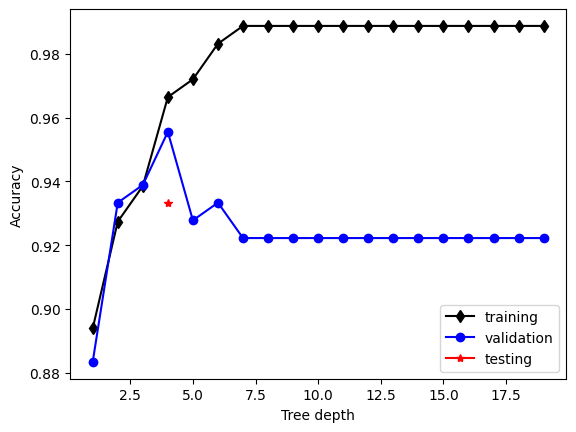

In [ ]:
best_depth = model_choices[np.argmax(valid_acc)]
dt = DecisionTree(max_depth=best_depth, cost_fn=cost_entropy) # Here you will notice cost_entropy as a parameter
y_test_prob = dt.fit(x_train_breast, y_train_breast).predict(x_test_breast)
y_test_pred = np.argmax(y_test_prob, axis=-1)
test_accuracy = np.sum(y_test_pred == y_test_breast)/y_test_breast.shape[0]
print(f'BCW best depth = {best_depth}, BCW test accuracy = {test_accuracy}')

plt.plot(model_choices, train_acc, marker='d', color='black', label='training')
plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
plt.plot(best_depth, test_accuracy, marker='*', color='red', label='testing')
plt.xlabel("Tree depth")
plt.ylabel("Accuracy")
plt.legend(loc='best')

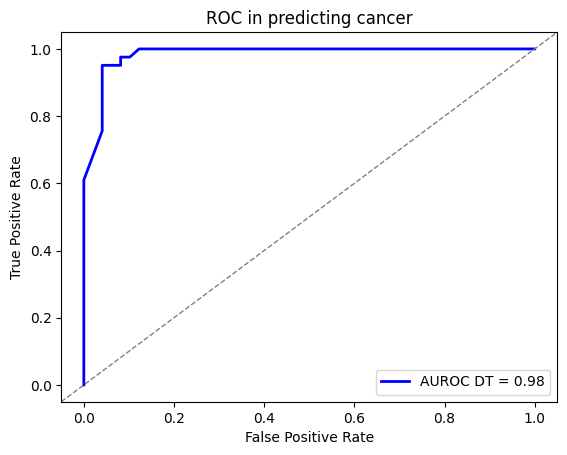

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, roc_auc_score

fpr1, tpr1, threshold1 = roc_curve(y_test_breast, y_test_prob[:, 1], pos_label=1)
roc_auc1 = roc_auc_score(y_test_breast, y_test_prob[:, 1])

plt.clf()
plt.plot(fpr1, tpr1, "b-", lw=2, label="AUROC DT = %0.2f"%roc_auc1)

plt.axline((0, 0), (1, 1), linestyle="--", lw=1, color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC in predicting cancer')
plt.legend(loc="best")

In [ ]:
results = pd.DataFrame({
    'y_test_breast': y_test_breast,
    'y-pred_breast': y_test_prob[:, 1]
})

results.to_csv('breast_ROC.csv')
print(results)

    y_test_breast  y-pred_breast
0               0       0.000000
1               0       0.555556
2               0       0.000000
3               1       0.918919
4               0       0.000000
..            ...            ...
85              0       0.000000
86              0       0.000000
87              1       1.000000
88              0       0.000000
89              1       0.954545

[90 rows x 2 columns]


# NHANES Experiments:

In [ ]:
# Accuracy at best tree depth:

misclassification_tree = DecisionTree(max_depth=4, cost_fn=cost_misclassification)
gini_tree = DecisionTree(max_depth=4, cost_fn=cost_gini_index)
entropy_tree = DecisionTree(max_depth=4, cost_fn=cost_entropy)

probs_test = misclassification_tree.fit(x_train_nhanes, y_train_nhanes).predict(x_test_nhanes)
y_pred = np.argmax(probs_test,1)
m_accuracy = np.sum(y_pred == y_test_nhanes)/y_test_nhanes.shape[0]

probs_test = gini_tree.fit(x_train_nhanes, y_train_nhanes).predict(x_test_nhanes)
y_pred = np.argmax(probs_test,1)
g_accuracy = np.sum(y_pred == y_test_nhanes)/y_test_nhanes.shape[0]

probs_test = entropy_tree.fit(x_train_nhanes, y_train_nhanes).predict(x_test_nhanes)
y_pred = np.argmax(probs_test,1)
e_accuracy = np.sum(y_pred == y_test_nhanes)/y_test_nhanes.shape[0]

accuracy_values = {"Accuracy": [m_accuracy*100, g_accuracy*100, e_accuracy*100]}
df_accuracy = pd.DataFrame(accuracy_values, index = ["Misclassification", "Gini Index", "Entropy"])
print('Top 3 Features:\n', df_accuracy)

Top 3 Features:
                    Accuracy
Misclassification     100.0
Gini Index            100.0
Entropy               100.0


# Training/Validation Split:

In [ ]:
x_train_tr, y_train_tr = x_train_nhanes[:179], y_train_nhanes[:179]
x_train_va, y_train_va = x_train_nhanes[179:], y_train_nhanes[179:]

model_choices=[]
train_acc = []
valid_acc = []

n_train = y_train_tr.shape[0]
n_valid = y_train_va.shape[0]

for k in range(1, 20):
    dt = DecisionTree(max_depth=k)

    y_train_tr_prob = dt.fit(x_train_tr, y_train_tr).predict(x_train_tr)
    y_train_tr_pred = np.argmax(y_train_tr_prob, axis=-1)
    acc_tr = np.sum(y_train_tr_pred == y_train_tr)/n_train

    y_train_va_prob = dt.fit(x_train_tr, y_train_tr).predict(x_train_va)
    y_train_va_pred = np.argmax(y_train_va_prob, axis=-1)
    acc_va = np.sum(y_train_va_pred == y_train_va)/n_valid

    model_choices.append(k)
    train_acc.append(acc_tr)
    valid_acc.append(acc_va)

# Example with best depth (all cost functions return 100% accuracy):

BCW best depth = 1, BCW test accuracy = 1.0


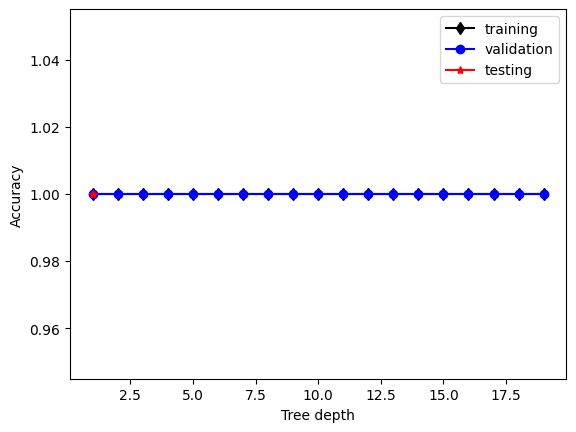

In [ ]:
best_depth = model_choices[np.argmax(valid_acc)]
dt = DecisionTree(max_depth=best_depth, cost_fn=cost_entropy) # Here you will notice cost_entropy as a parameter
y_test_prob = dt.fit(x_train_nhanes, y_train_nhanes).predict(x_test_nhanes)
y_test_pred = np.argmax(y_test_prob, axis=-1)
test_accuracy = np.sum(y_test_pred == y_test_nhanes)/y_test_nhanes.shape[0]
print(f'BCW best depth = {best_depth}, BCW test accuracy = {test_accuracy}')

plt.plot(model_choices, train_acc, marker='d', color='black', label='training')
plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
plt.plot(best_depth, test_accuracy, marker='*', color='red', label='testing')
plt.xlabel("Tree depth")
plt.ylabel("Accuracy")
plt.legend(loc='best')

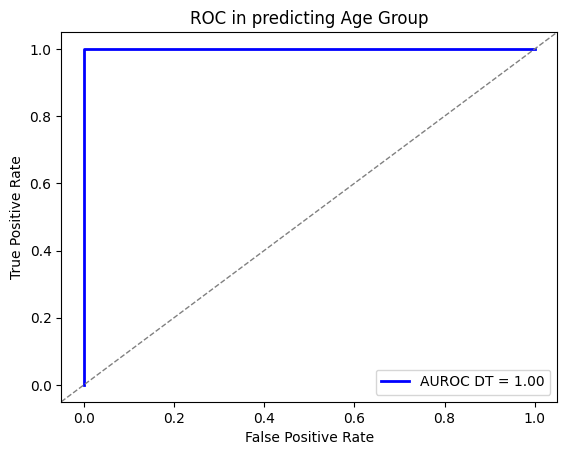

In [ ]:
fpr1, tpr1, threshold1 = roc_curve(y_test_nhanes, y_test_prob[:, 1], pos_label=1)
roc_auc1 = roc_auc_score(y_test_nhanes, y_test_prob[:, 1])

plt.clf()
plt.plot(fpr1, tpr1, "b-", lw=2, label="AUROC DT = %0.2f"%roc_auc1)

plt.axline((0, 0), (1, 1), linestyle="--", lw=1, color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC in predicting Age Group')
plt.legend(loc="best")

In [ ]:
results = pd.DataFrame({
    'y_test_nhanes': y_test_nhanes,
    'y-pred_nhanes': y_test_prob[:, 1]
})

results.to_csv('nhanes_ROC.csv')
print(results)

     y_test_nhanes  y-pred_nhanes
0                0            0.0
1                0            0.0
2                0            0.0
3                0            0.0
4                0            0.0
..             ...            ...
451              1            1.0
452              0            0.0
453              0            0.0
454              1            1.0
455              0            0.0

[456 rows x 2 columns]


# Experiments: Evaluation of DT model
The evaluation of the decision tree model was measured for a range of maximum depth k for k = [1, 20] using three separate training costs and finding the best depth for each. The range of k depth values was chosen to give general context to the results after preliminary tests showed significant diminishing returns in accuracy variance after a max depth of k » 7. The training costs implemented were chosen as misclassification rate, entropy, and gini index. The implementation of the same decision tree iteration using various training cost calculations highlights the strengths, weaknesses, and similarities of each in the results. General attributes of each training cost are as follows:

  * Misclassification measures the total proportion of misclassified samples and has the potential to be insensitive as a training cost as a result (Source in report)

  * Entropy refers to the amount of uncertainty present at a given node and is calculated by evaluating the potential split from each input variable across the possible outcomes. The lower the entropy, the more information is gained increasing decision accuracy (Source in report)

  * The gini index is commonly used as the default cost function for decision tree architectures (such as in sklearn) and calculates how likely a variable is to be misclassified. In this case, low values also equate to increased decision accuracy (Source in report)

  * NHANES DT Results

Model | Misclassification | Entropy | Gini |
    :---: |:---: | :---: | :---: |
    `Evaluation Accuracy` | 1.0 | 1.0 | 1.0 |
    `AUCROC` | 1.0 | 1.0 | 1.0 |
    `Best Depth` | 1 | 1 | 1 | 1|
    
  * BREAST CANCER DT Results

Model | Misclassification | Entropy | Gini |
    :---: |:---: | :---: | :---: |
    `Evaluation Accuracy` | 0.9555556 | 0.9333333 | 0.9555556 |
    `AUCROC` | 0.95 | 0.98 | 0.95 |
    `Best Depth` | 4 | 4 | 4 | 4|
            
In the case of the NHANES dataset, the model performed optimally under all conditions. We see subtle shifts in accuracy in the BREAST CANCER implementation, notably when using entropy as the training cost, which resulted in a slight decrease in accuracy measurements but a slight increase in AUCROC. Overall, the accuracy of the model is functionally consistent across all hyperparameters and cost functions.

# Plotting AUC Curves of KNN vs DT on both datasets

<ipython-input-157-ee8445bd972f>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target.replace(4, 1, inplace=True)
<ipython-input-157-ee8445bd972f>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target.replace(2, 0, inplace=True)


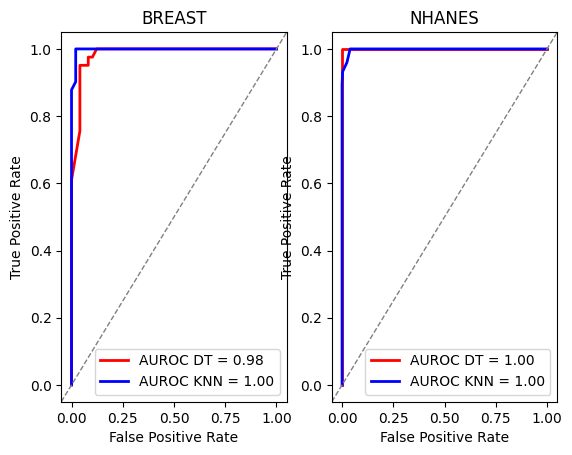

In [ ]:
target = pd.read_csv('processed_BREAST_data_top_3_features.csv')
target_nhanes = pd.read_csv('processed_NHANES_data_top_3_features.csv')

DT_BCW = pd.read_csv('breast_ROC.csv')
DT_NHANES = pd.read_csv('nhanes_ROC.csv')

KNN_BCW = pd.read_csv('breast_knn_experiments_best_hyperparameters_results.csv')
KNN_NHANES = pd.read_csv('nhanes_knn_experiments_best_hyperparameters_results.csv')

def create_dataset_split(dataset: pd.DataFrame, create_val: bool = False) -> Tuple:
    train, test = train_test_split(dataset, test_size=0.2, random_state=42)
    if create_val:
        train, val = train_test_split(train, test_size=0.2, random_state=42)
        return train, val, test
    else:
        return train, test

breast_train, breast_test = create_dataset_split(target)
nhanes_train, nhanes_test = create_dataset_split(target_nhanes)

DT_BCW_pred = DT_BCW[['y-pred_breast']]
KNN_BCW_pred = KNN_BCW[['breast_predict_proba']]

DT_NHANES_pred = DT_NHANES[['y-pred_nhanes']]
KNN_NHANES_pred = KNN_NHANES[['nhanes_predict_proba']]

target = breast_test[['Class']]
target.replace(4, 1, inplace=True)
target.replace(2, 0, inplace=True)

target_nhanes = nhanes_test[['age_group']]

fpr1, tpr1, thresholds = roc_curve(target, DT_BCW_pred, pos_label=1)
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, thresholds = roc_curve(target, KNN_BCW_pred, pos_label=1)
roc_auc2 = auc(fpr2, tpr2)


# create 2 subplots
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].plot(fpr1, tpr1, "r-", lw=2, label="AUROC DT = %0.2f"%roc_auc1)
ax[0].plot(fpr2, tpr2, "b-", lw=2, label="AUROC KNN = %0.2f"%roc_auc2)
ax[0].axline((0, 0), (1, 1), linestyle="--", lw=1, color='gray')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('BREAST')
ax[0].legend(loc="best")

nhanes_fpr1, nhanes_tpr1, _ = roc_curve(target_nhanes, DT_NHANES_pred, pos_label=1)
nhanes_roc_auc1 = auc(nhanes_fpr1, nhanes_tpr1)

nhanes_fpr2, nhanes_tpr2, thresholds = roc_curve(target_nhanes, KNN_NHANES_pred, pos_label=1)
nhanes_roc_auc2 = auc(nhanes_fpr2, nhanes_tpr2)

ax[1].plot(nhanes_fpr1, nhanes_tpr1, "r-", lw=2, label="AUROC DT = %0.2f"%nhanes_roc_auc1)
ax[1].plot(nhanes_fpr2, nhanes_tpr2, "b-", lw=2, label="AUROC KNN = %0.2f"%nhanes_roc_auc2)
ax[1].axline((0, 0), (1, 1), linestyle="--", lw=1, color='gray')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('NHANES')
ax[1].legend(loc="best")
plt.savefig('dt_vs_knn.png')
plt.show()